## Set-up

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from pprint import pprint
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#!pwd
import os

# Google Bucket
# file name checkpoint_0512_sent_split.parquet
path_bucket = 'gs://msca-sp23-bucket/nlp_data'
runtime_path = '/home/anthony/projects/nlp_runtime'
bucket_read = path_bucket + '/' + 'checkpoint_0524_lda_data_lda_8_topics.parquet'

os.chdir(runtime_path)
print(os.getcwd())

/home/anthony/projects/nlp_runtime


In [3]:
import spacy

2023-05-25 04:04:33.802037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 04:04:34.801794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import en_core_web_md
nlp = spacy.load("en_core_web_md")

## Preparation

In [5]:
df_raw = pd.read_parquet(bucket_read, engine='pyarrow')
df_raw.head(3)

,url,date,title,text_cleaned,text_lda,tokens,topic
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. So...","Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. So...","[artificial, intelligence, improve, parking, efficiency, chinese, city, people, daily, online, chinese, japanese, french, spanish, russian, arabic, korean, german, portuguese, thursday, march, home, artificial, intelligence, improve, parking, efficiency, chinese, city, liu, shiyao, people, daily, march, photo, take, july, show, sign, electronic, toll, collection, etc, set, roadside, parking, space, yangzhuang, road, shijingshan, district, beijing, urban, area, city, start, use, etc, system, ...",0
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the nex...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the nex...","[children, autism, see, learning, social, skills, boost, play, ai, robot, news, parliament, children, autism, see, learning, social, skills, boost, play, ai, robot, author, recent, posts, admin, late, post, admin, mansplaining, conference, forestall, february, coronavirus, explode, overnight, like, italy, february, levi, strauss, mark, phase, corporate, pay, leave, policy, february, scientist, design, clever, robotic, help, youngster, autism, spice, study, social, talent, hope, era, future, ...",6
2,http://www.dataweek.co.za/12835r,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","Forget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek Home About us Back issues / E book / PDF EMP Handbook Subscribe Advertise Editor's Choice Multimedia, Videos Analogue, Mixed Signal, LSI Circuit System Protection Computer/Embedded Technology Design Automation DSP, Micros Memory Electronics Technology Enclosures, Racks, Cabinets Panel Products Events Inter

In [6]:
# rename column: text_lda -> text_40_percent
df_raw.rename(columns={'text_lda':'text_40_pct'}, inplace=True)

## News source check and filtering

I want to control for sources of reputation and good quality. So, here are the steps:
- extract domain names
- count the number of articles per domain name in this dataset
- expplore the distribution of publications by domain name
- make decision on filtering

In [7]:
import re

In [8]:
# extract domain name from url
df_raw['domain'] = df_raw['url'].parallel_apply(lambda x: re.match(r"^(?:https?:\/\/)?(?:www\.)?([^\/\n]+)", x).group(1))

In [9]:
df_raw[['url', 'domain']].head(2)

,url,domain
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,en.people.cn
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,newsparliament.com


In [17]:
# count frequency by domain
domain_counts = df_raw['domain'].value_counts().sort_values(ascending=False)

In [18]:
domain_counts.describe()

count    5412.000000
mean       34.271803
std       130.443829
min         1.000000
25%         1.000000
50%         4.000000
75%        16.000000
max      3209.000000
Name: count, dtype: float64

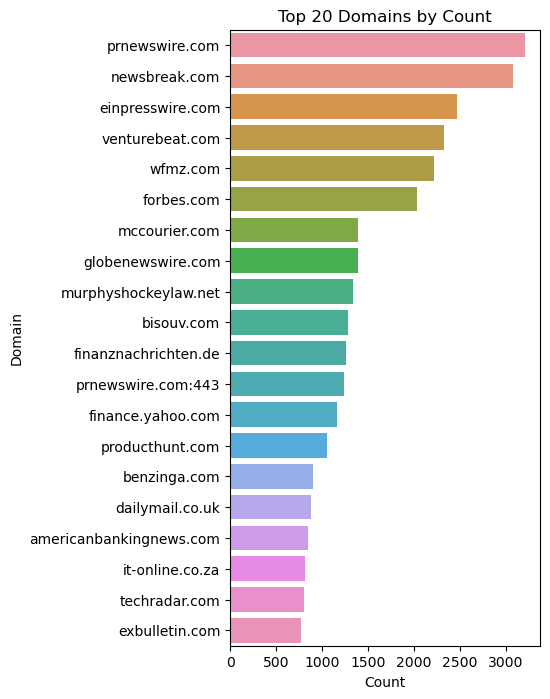

In [12]:
# get top 10 domains
domain_counts = df_raw['domain'].value_counts().sort_values(ascending=False).head(20)

# plot the distribution of counts by domain
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 8), dpi=100)
sns.barplot(x=domain_counts.values, y=domain_counts.index)
plt.title('Top 20 Domains by Count')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.show()

In [19]:
domain_counts = df_raw['domain'].value_counts().sort_values(ascending=False)

# total number of domains from the dataset
print(f'Total number of domain names {len(domain_counts)}')
print(f'Total number of news articles {domain_counts.sum()}')
print(f'Top 100 domain names has {domain_counts[:100].sum()} articles')

Total number of domain names 5412
Total number of news articles 185479
Top 100 domain names has 72386 articles


In [20]:
# get domain names that publish more than 100 articles
frequent_publisher = domain_counts[domain_counts > 100]

# their tottotal number of articles over the total number of articles
frequent_publisher_article_ratio = 100 * domain_counts[domain_counts > 100].sum() / domain_counts.sum()
frequent_publisher_article_ratio = round(frequent_publisher_article_ratio, 3)

# number of frequent publishers over all publishers(domains)
frequent_publisher_count = 100*(len(frequent_publisher) / len(domain_counts))
frequent_publisher_ratio = round(frequent_publisher_count, 3)

print(f'There are {len(frequent_publisher)} frequent publishers that publish more than 100 articles')
print(f'These publishers take up {frequent_publisher_ratio}% of total publishers (aka. domains)')
print(f'Their articles of publications take up {frequent_publisher_article_ratio}% of total articles')

There are 352 frequent publishers that publish more than 100 articles
These publishers take up 6.504% of total publishers (aka. domains)
Their articles of publications take up 70.231% of total articles


From above we see that: 
1. there are 5412 domain names; in other words, 5412 new sources
2. the total number of articles is 185479, while the top 100 domain names (based on counts of articles per domain) publish 117319 articles (roughly 63% of the total articles)
3. only the top 75% domains that have more than 16 articles published
4. only 6.5% domains have publihsed more than 100 articles; and the sum of their publications takes up 70% of the total articles

**Short summary**

The purpose for this section is to figure out what sources--specifically, domain names--are valuable in covering AI-related news. With emphrasis on such domain names, the number of articles can be reduced to a smaller scale so that the processing efficiency can be improved. The rationale is that if a topic is important then the popular publishers (domain names) will cover it.

The trade off of this method is the issue of when minor topics are covered but with few publications, or when reputable sources (e.g. Ruters, NYT) have less publications while less reputable sources with more reposts/ origibal articles in this dataset. In addition, new websites will repost articles from each other, thereby the counts of publication do not reflect the its news coverage, quality of report, and weight of reputation.

## Adding credential news domain to the filter list

In this section, I want to see if I add credible sources to the filter.

In [21]:
# take bbc for example
df_raw[df_raw['domain'].str.contains('bbc.co.uk')].count()

url             119
date            119
title           119
text_cleaned    119
text_40_pct     119
tokens          119
topic           119
domain          119
dtype: int64

In [22]:
# take bbc for example
df_raw[df_raw['domain'].str.contains('bbc.com')].count()

url             84
date            84
title           84
text_cleaned    84
text_40_pct     84
tokens          84
topic           84
domain          84
dtype: int64

In [55]:
domain_names_patch = [
    "washingtonpost","nytimes","cnn","bbc","theguardian","reuters",
    "bloomberg","forbes","wsj","economist","ft","businessinsider","cnbc",
    "techcrunch","zdnet","venturebeat","abcnews","usatoday","nbcnews","latimes",
    "foxnews","apnews","huffpost","usatoday","npr","thetimes","independent",
    "mirror","telegraph","express","chronicle","financialtimes","dailymail",
    "aimagazine", "analyticsinsight", "aitrends", "news.mit", "wired.co.uk",
    "openai.com", "emerj.com", "extremetech.com", "technologyreview", "microsof",
    "google", "amazon", "facebook", "twitter", "apple", "ibm", "intel", "nvidia",
    "goldmansachs", "jpmorgan", "morganstanley", "bankofamerica", "citi", "wellsfargo"]

In [56]:
# get domain names that publish more than 100 articles
domain_filter_list = frequent_publisher.index.tolist()

In [57]:
# use domain_names_patch to filter out domain names
def domain_filter(domain):
    match_status = False
    if isinstance(domain, str):
        for domain_name in domain_filter_list: # e.g. washingtonpost.com == washingtonpost.com
            if (domain_name == domain):
                match_status = True
            else:
                for domain_name in domain_names_patch: # e.g. bbc in bbc.co.uk
                    if domain_name in domain:
                        match_status = True
    return match_status

df_filtered = df_raw[df_raw['domain'].parallel_apply(domain_filter)]

In [58]:
# check the filtered results
domain_counts = df_filtered['domain'].value_counts().sort_values(ascending=False)
domain_counts.describe()

count     557.000000
mean      239.242370
std       340.729994
min         1.000000
25%        10.000000
50%       141.000000
75%       402.000000
max      3209.000000
Name: count, dtype: float64

In [59]:
# check total number of articles
filtered_ratio = round((100*domain_counts.sum() / df_raw['domain'].value_counts().sum()), 3)

print(f'There are {len(domain_counts)} frequent publishers found')
print(f'Total number of aricitles of filtered dataframe is {domain_counts.sum()},')
print(f'which is {filtered_ratio}% of the total number of articles')

There are 557 frequent publishers found
Total number of aricitles of filtered dataframe is 133258,
which is 71.845% of the total number of articles


In [60]:
df_filtered.head(3)

,url,date,title,text_cleaned,text_40_pct,tokens,topic,domain
4,http://www.itbusinessnet.com/2020/10/olympus-to-support-endoscopic-ai-diagnosis-education-for-doctors-in-india-and-to-launch-ai-diagnostic-support-application/?utm_source=rss&utm_medium=rss&utm_campaign=olympus-to-support-endoscopic-ai-diagnosis-education-for-doctors-in-india-and-to-launch-ai-diagnostic-support-application,2020-10-20,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net,"Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application IT Business Net Skip to content Search for: to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application News Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application TOKYO, Oct 2...","Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application IT Business Net Skip to content Search for: to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application News Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application TOKYO, Oct 2...","[olympus, support, endoscopic, ai, diagnosis, education, doctors, india, launch, ai, diagnostic, support, application, business, net, skip, content, search, support, endoscopic, ai, diagnosis, education, doctors, india, launch, ai, diagnostic, support, application, news, olympus, support, endoscopic, ai, diagnosis, education, doctors, india, launch, ai, diagnostic, support, application, tokyo, oct, acn, newswire, olympus, corporation, take, ground, break, project, business, promoter, coopera...",0,itbusinessnet.com
8,https://3wnews.org/uncategorised/1351502/artificial-intelligence-in-behavioral-and-mental-health-care-market-to-witness-astonishing-growth-by-2026-focusing-on-leading-players-advancedmd-cerner-core-solutions-credible-behavioral-healt/,2020-06-14,"Artificial Intelligence In Behavioral And Mental Health Care Market to Witness Astonishing Growth by 2026 Focusing on Leading Players – AdvancedMD , Cerner , Core Solutions , Credible Behavioral Health – 3w Market News Reports","Artificial Intelligence In Behavioral And Mental Health Care Market to Witness Astonishing Growth by 2026 Focusing on Leading Players AdvancedMD , Cerner , Core Solutions , Credible Behavioral Health 3w Market News Reports 3rd Market Reports and Analytics News Market Reports Industry Analytics Industry Reports Market Research Business Opportunity Emerging Trends Growth Prospects You are hereHomeGlobal NewsArtificial Intelligence In Behavioral And Mental Health Care Market to Witness A...","Artificial Intelligence In Behavioral And Mental Health Care Market to Witness Astonishing Growth by 2026 Focusing on Leading Players AdvancedMD , Cerner , Core Solutions , Credible Behavioral Health 3w Market News Reports 3rd Market Reports and Analytics News Market Reports Industry Analytics Industry Reports Market Research Business Opportunity Emerging Trends Growth Prospects You are hereHomeGlobal NewsArtificial Intelligence In Behavioral And Mental Health Care Market to Witness A...","[artificial, intelligence, behavioral, mental, health, care, market, witness, astonishing, growth, focus, lead, players, advancedmd, cerner, core, solutions, credible, behavioral, health, market, news, report, market, reports, analytics, news, market, reports, industry, analytics, industry, reports, market, research, business, opportunity, emerging, trend, growth, prospect, herehomeglobal, newsartificial, intelligence, behavioral, mental, health, care, market, witness, astonishing, growth, f...",0,3wnews.org
9,https://3wnews.org/uncategorised/2350145/ai-machine-learning-market-2020-expected-to-reach-xx-million-b

In [69]:
# convert date (YYYY-MM-DD) to datetime
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# sort by date, ascending
df_filtered.sort_values(by='date', inplace=True)

# reset index
df_filtered.reset_index(drop=True, inplace=True)

In [73]:
# prepare before split into sentences

# rename columns
df_filtered.rename(columns={'topic': 'article_topic'}, inplace=True)

# add article id (start from 1)
df_filtered['article_id'] = df_filtered.index + 1

In [77]:
# check length to estimate processing time
article_length = df_filtered['text_cleaned'].parallel_apply(lambda x: len(x.split()))

In [78]:
article_length.describe()

count    133258.000000
mean       1139.964385
std         914.733843
min           9.000000
25%         724.000000
50%         958.000000
75%        1327.000000
max       41738.000000
Name: text_cleaned, dtype: float64

In [79]:
df_filtered.head(1)

,url,date,title,text_cleaned,text_40_pct,tokens,article_topic,domain,article_id
0,https://theenterpriseleader.com/2020/01/01/decentralized-machine-learning-reaches-market-cap-of-15919-00-dml.html,2020-01-01,"Decentralized Machine Learning Reaches Market Cap of $15,919.00 (DML) - Enterprise Leader","Decentralized Machine Learning Reaches Market Cap of 15,919.00 DML Enterprise Leader Daily Ratings News for Decentralized Machine Learning Complete the form below to receive the latest headlines and analysts' mendations for Decentralized Machine Learning with our free daily email newsletter: Follow EnterpriseLeade Recent Posts GE Announces Its Plan To Sell The Distributed Power Business To Advent International Ebang Communication Resorts To The Filing Of An IPO In Hong Ko...","Decentralized Machine Learning Reaches Market Cap of 15,919.00 DML Enterprise Leader Daily Ratings News for Decentralized Machine Learning Complete the form below to receive the latest headlines and analysts' mendations for Decentralized Machine Learning with our free daily email newsletter: Follow EnterpriseLeade Recent Posts GE Announces Its Plan To Sell The Distributed Power Business To Advent International Ebang Communication Resorts To The Filing Of An IPO In Hong Ko...","[decentralize, machine, learning, reach, market, cap, dml, enterprise, leader, daily, ratings, news, decentralized, machine, learning, complete, form, receive, late, headline, analyst, mendation, decentralized, machine, learning, free, daily, email, newsletter, follow, enterpriseleade, recent, posts, ge, announce, plan, sell, distributed, power, business, advent, international, ebang, communication, resorts, filing, ipo, hong, kong, open, daa, vcd, nrg, img, mdf, files, smart, risky, way, te...",3,theenterpriseleader.com,1


In [96]:
# split into sentences with full articles

# remove unnecessary columns
df_full = df_filtered[[i for i in df_filtered.columns if i not in ['text_40_pct', 'tokens']]]

# remove ,ultiple consecutive spaces
df_full['text_cleaned'] = df_full['text_cleaned'].parallel_apply(lambda x: re.sub(r'\s+', ' ', x))

In [97]:
df_full.head(1)

,url,date,title,text_cleaned,article_topic,domain,article_id
0,https://theenterpriseleader.com/2020/01/01/decentralized-machine-learning-reaches-market-cap-of-15919-00-dml.html,2020-01-01,"Decentralized Machine Learning Reaches Market Cap of $15,919.00 (DML) - Enterprise Leader","Decentralized Machine Learning Reaches Market Cap of 15,919.00 DML Enterprise Leader Daily Ratings News for Decentralized Machine Learning Complete the form below to receive the latest headlines and analysts' mendations for Decentralized Machine Learning with our free daily email newsletter: Follow EnterpriseLeade Recent Posts GE Announces Its Plan To Sell The Distributed Power Business To Advent International Ebang Communication Resorts To The Filing Of An IPO In Hong Kong How to Open DAA, ...",3,theenterpriseleader.com,1


In [105]:
# save a checkpoint for the filtered dataframe (with full articles)
#df_full.to_parquet(path_bucket + '/' + 'checkpoint_0524_source_filtered_full_article.parquet', engine='pyarrow')

Note:
- Maybe we can limit the length of sentences (having len(sent) >=10)
- 

In [145]:
# split into sentences with full articles
text = df_full['text_cleaned']

# make containers
sentences = []
entities = []
pass_list = ['ai', 'intelligence ai', 'artificial intelligence ai', 'android', 'software', 
             'natural language processing nlp', 'inc.', 'org.', 'co.', 'ltd.', 'corp.']

# split into sentences with nlp pipe
for doc in nlp.pipe(text, batch_size=50, disable=['tok2vec', 'tagger', 'parser', 'senter', 'attribute_ruler', 'lemmatizer'], n_process=12):
    article_sents = [sent.text for sent in doc.sents]
    article_entities = [(ent.text, ent.label_) for ent in doc.ents 
                        if (ent.label_ in ["ORG", "PER", "LOC", "GPE"]) and (ent.text.lower() not in pass_list)]
    sentences.append(article_sents)
    entities.append(article_entities)

In [146]:
# save sentences and entities
df_full['sentences'] = sentences
df_full['entities'] = entities

In [147]:
# save the checkpoint
df_full.to_parquet(path_bucket + '/' + 'checkpoint_0524_full_article_split.parquet', engine='pyarrow')

In [148]:
df_full.shape

(133258, 9)

In [149]:
df_full.head(10)[['sentences', 'entities']]

,sentences,entities
0,"[Decentralized Machine Learning Reaches Market Cap of 15,919.00 DML Enterprise Leader Daily Ratings News for Decentralized Machine Learning Complete the form below to receive the latest headlines and analysts' mendations for Decentralized Machine Learning with our free daily email newsletter: Follow EnterpriseLeade Recent Posts GE Announces Its Plan To Sell The Distributed Power Business To Advent International Ebang Communication Resorts To The Filing Of An IPO In Hong Kong How to Open DAA,...","[(Decentralized Machine Learning Reaches Market Cap, ORG), (Decentralized Machine Learning, ORG), (Hong Kong, GPE), (NRG, ORG), (IMG, ORG), (Mistake Foxconn Launches Investigation After Reports Of Harsh Working Conditions, ORG), (Flagstar Bancorp, ORG), (Wells Fargo UK, ORG), (Royal Bank Of Scotland RBS, ORG), (France, GPE), (China, GPE), (FII IPO Uber, ORG), (Paris Deutsche Bank Plans To Slash, ORG), (Samsung, ORG), (Apple Back In Court, ORG), (Apple, ORG), (Goldman Sachs, ORG), (JPMorgan C..."
1,"[ Artificial Intelligence AI in Marketing Market Scope, Size, Share, Trends, Forecast by 2026 Market Reports Observer Skip to content 488 E 11th Ave, Eugene, OR 97401, USA 1 541 687 2347 email protected Market Reports Observer Artificial intelligence AI is the ability to process information in a way similar to the thought process of humans in learning, decision making, and problem solving., Enterprises are now identifying the value associated with integrating AI into their business processes...","[(USA, GPE), (Market Reports Observer Artificial, ORG), (North America, LOC), (South America, LOC), (Europe, LOC), (Asia Pacific, LOC), (Middle East Africa, LOC), (North America, LOC), (North America, LOC), (Asia Pacific, LOC), (Japan, GPE), (China, GPE), (India, GPE), (Europe, LOC), (Middle East Africa, LOC), (South America, LOC), (Artificial Intelligence AI in Marketing Market, ORG), (IBM Corporation, ORG), (Google Inc., ORG), (Intel Corporation, ORG), (Microsoft Corporation, ORG), (NVIDIA..."
2,"[ Lisk Machine Learning 24 Hour Trading Volume Tops 10.00 LML Markets Daily Home Privacy Policy About/ Contact Business Stocks Technology Health Lifestyle Politics Daily Ratings News for Lisk Machine Learning Complete the form below to receive the latest headlines and analysts' mendations for Lisk Machine Learning with our free daily email newsletter: Follow TheMarketsDaily Recent Posts TERA Price Down 14.5 Over Last 7 Days TERA Mindexcoin MIC Hits 1 Day Trading Volume of 1,347.00 Garlicoin ...","[(Lisk Machine Learning, ORG), (Lisk Machine Learning Complete, ORG), (Lisk Machine Learning, ORG), (Garlicoin GRLC Market Capitalization Achieves, ORG), (EVBG, ORG), (BroadVision NASDAQ, ORG), (BVSN Denny s Corp NASDAQ, ORG), (Teradyne, ORG), (TER, ORG), (Community Trust Bancorp, ORG), (LML, ORG), (US, GPE), (Lisk Machine Learning, ORG), (Lisk Machine Learning, ORG), (Lisk Machine Learning, ORG), (US, GPE), (Lisk Machine Learning, ORG), (Bitcoin SV BSV, ORG), (TRON TRX, ORG), (Neo NEO, ORG)..."
3,[ Google's AI can detect breast cancer more accurately than experts Engadget Engadget Login Home Reviews Gear Gaming Entertainment Tomorrow Audio Video Deals Buyer's Guide Holiday Gift Guide Fitness Tech Home Entertainment Personal Security Back to School Outdoor Tech Parenting and Tech Camera Guide Best of CES Phones Laptops View All Log in Sign up Engadget 3 related articles Login WSJ: FDA vape ban will target fruit flavored pods Scientist who edited babies' genes sentenced to three years ...,"[(Google, ORG), (Engadget Engadget Login Home Reviews, ORG), (Login WSJ, ORG), (FDA, ORG), (Scientist, ORG), (New York, GPE), (Apple, ORG), (Google, ORG), (EUV, ORG), (SpaceX, ORG), (the ISS Scientist, ORG), (Google, ORG), (georginatorbet 2h ago, ORG), (Medicine BSIP, ORG), (UK, GPE), (Google, ORG), (mon, ORG), (US, GPE), (UK, GPE), (US, GPE), (UK, GPE), (US, GPE), (UK, GPE), (UK, GPE), (National Health System, ORG), (UK, GPE), (NHS, ORG), (Google Health,